In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.editor import enrich_schedule_dframe
from src.utils.initialization import jobs_jssp_init as init

from src.utils.initialization.gen_deadlines import get_temporary_df_times_from_schedule, ensure_reasonable_deadlines
from src.utils.analysis_basics.check_gen_deadlines import plotfig_empirical_flow_budget_distributions
from src.utils.initialization.gen_deadlines import add_groupwise_lognormal_deadlines_by_group_mean

# Data access
from configs.path_manager import get_path

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)


In [2]:
# Data paths
basic_data_path = get_path("data", "basic")
examples_data_path = get_path("data", "examples")

In [3]:
df_routings = pd.read_csv(basic_data_path / "ft10_routings.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


In [4]:
day_count = 360

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = day_count, shift_length = 1440,
                                                        u_b_mmax = 0.92, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,0,1440
1,J25-0001,6,49,1440
2,J25-0002,0,116,1440
3,J25-0003,2,160,1440
4,J25-0004,3,203,1440
5,J25-0005,1,409,1440
...,...,...,...,...
7407,J25-7407,1,517827,518400
7408,J25-7408,7,517932,518400
7409,J25-7409,4,518012,518400


In [5]:
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
74124,J25-7412,2,4,M08,90
74125,J25-7412,2,5,M05,10
74126,J25-7412,2,6,M07,12


## I. Simulation

In [6]:
df_problem = df_jssp.merge(
    df_jobs_arrivals[['Job', 'Routing_ID','Arrival', 'Ready Time']],
    on=['Job', 'Routing_ID'],
    how='left'
)
df_problem

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time
0,J25-0000,8,0,M00,76,0,1440
1,J25-0000,8,1,M01,69,0,1440
2,J25-0000,8,2,M03,76,0,1440
3,J25-0000,8,3,M05,51,0,1440
4,J25-0000,8,4,M02,85,0,1440
5,J25-0000,8,5,M09,11,0,1440
...,...,...,...,...,...,...,...
74124,J25-7412,2,4,M08,90,518358,518400
74125,J25-7412,2,5,M05,10,518358,518400
74126,J25-7412,2,6,M07,12,518358,518400


In [7]:
simulation = ProductionSimulation(earliest_start_column = "Ready Time", sigma = 0, verbose = False)
simulation.run(df_problem, start_time = 0, end_time = None)

In [8]:
df_fcfs_execution = simulation.get_finished_operations_df()
df_fcfs_execution

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,1440.0,76.0,1516.0
1,J25-0000,1,M01,1874.0,69.0,1943.0
2,J25-0000,2,M03,1982.0,76.0,2058.0
3,J25-0000,3,M05,2058.0,51.0,2109.0
4,J25-0000,4,M02,2200.0,85.0,2285.0
5,J25-0000,5,M09,2285.0,11.0,2296.0
...,...,...,...,...,...,...
74124,J25-7412,4,M08,519820.0,90.0,519910.0
74125,J25-7412,5,M05,519912.0,10.0,519922.0
74126,J25-7412,6,M07,519922.0,12.0,519934.0


In [9]:
df_fcfs_execution = enrich_schedule_dframe(df_fcfs_execution, df_jobs_arrivals)
df_fcfs_execution

,Job,Operation,Machine,Start,Processing Time,End,Routing_ID,Arrival,Ready Time
0,J25-0000,0,M00,1440.0,76.0,1516.0,8,0,1440
1,J25-0000,1,M01,1874.0,69.0,1943.0,8,0,1440
2,J25-0000,2,M03,1982.0,76.0,2058.0,8,0,1440
3,J25-0000,3,M05,2058.0,51.0,2109.0,8,0,1440
4,J25-0000,4,M02,2200.0,85.0,2285.0,8,0,1440
5,J25-0000,5,M09,2285.0,11.0,2296.0,8,0,1440
...,...,...,...,...,...,...,...,...,...
74124,J25-7412,4,M08,519820.0,90.0,519910.0,2,518358,518400
74125,J25-7412,5,M05,519912.0,10.0,519922.0,2,518358,518400
74126,J25-7412,6,M07,519922.0,12.0,519934.0,2,518358,518400


In [10]:
if day_count <= 5:
    gantt.get_plot(df_fcfs_execution, perspective="Machine")

In [11]:
df_jobs_times_temp = get_temporary_df_times_from_schedule(df_fcfs_execution, df_jssp)
df_jobs_times_temp

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time
0,J25-0000,8,0,1440,2898.0,597
1,J25-0001,6,49,1440,2329.0,416
2,J25-0002,0,116,1440,3024.0,395
3,J25-0003,2,160,1440,2496.0,568
4,J25-0004,3,203,1440,2789.0,655
5,J25-0005,1,409,1440,2695.0,510
...,...,...,...,...,...,...
7407,J25-7407,1,517827,518400,519820.0,510
7408,J25-7408,7,517932,518400,520464.0,539
7409,J25-7409,4,518012,518400,520466.0,393


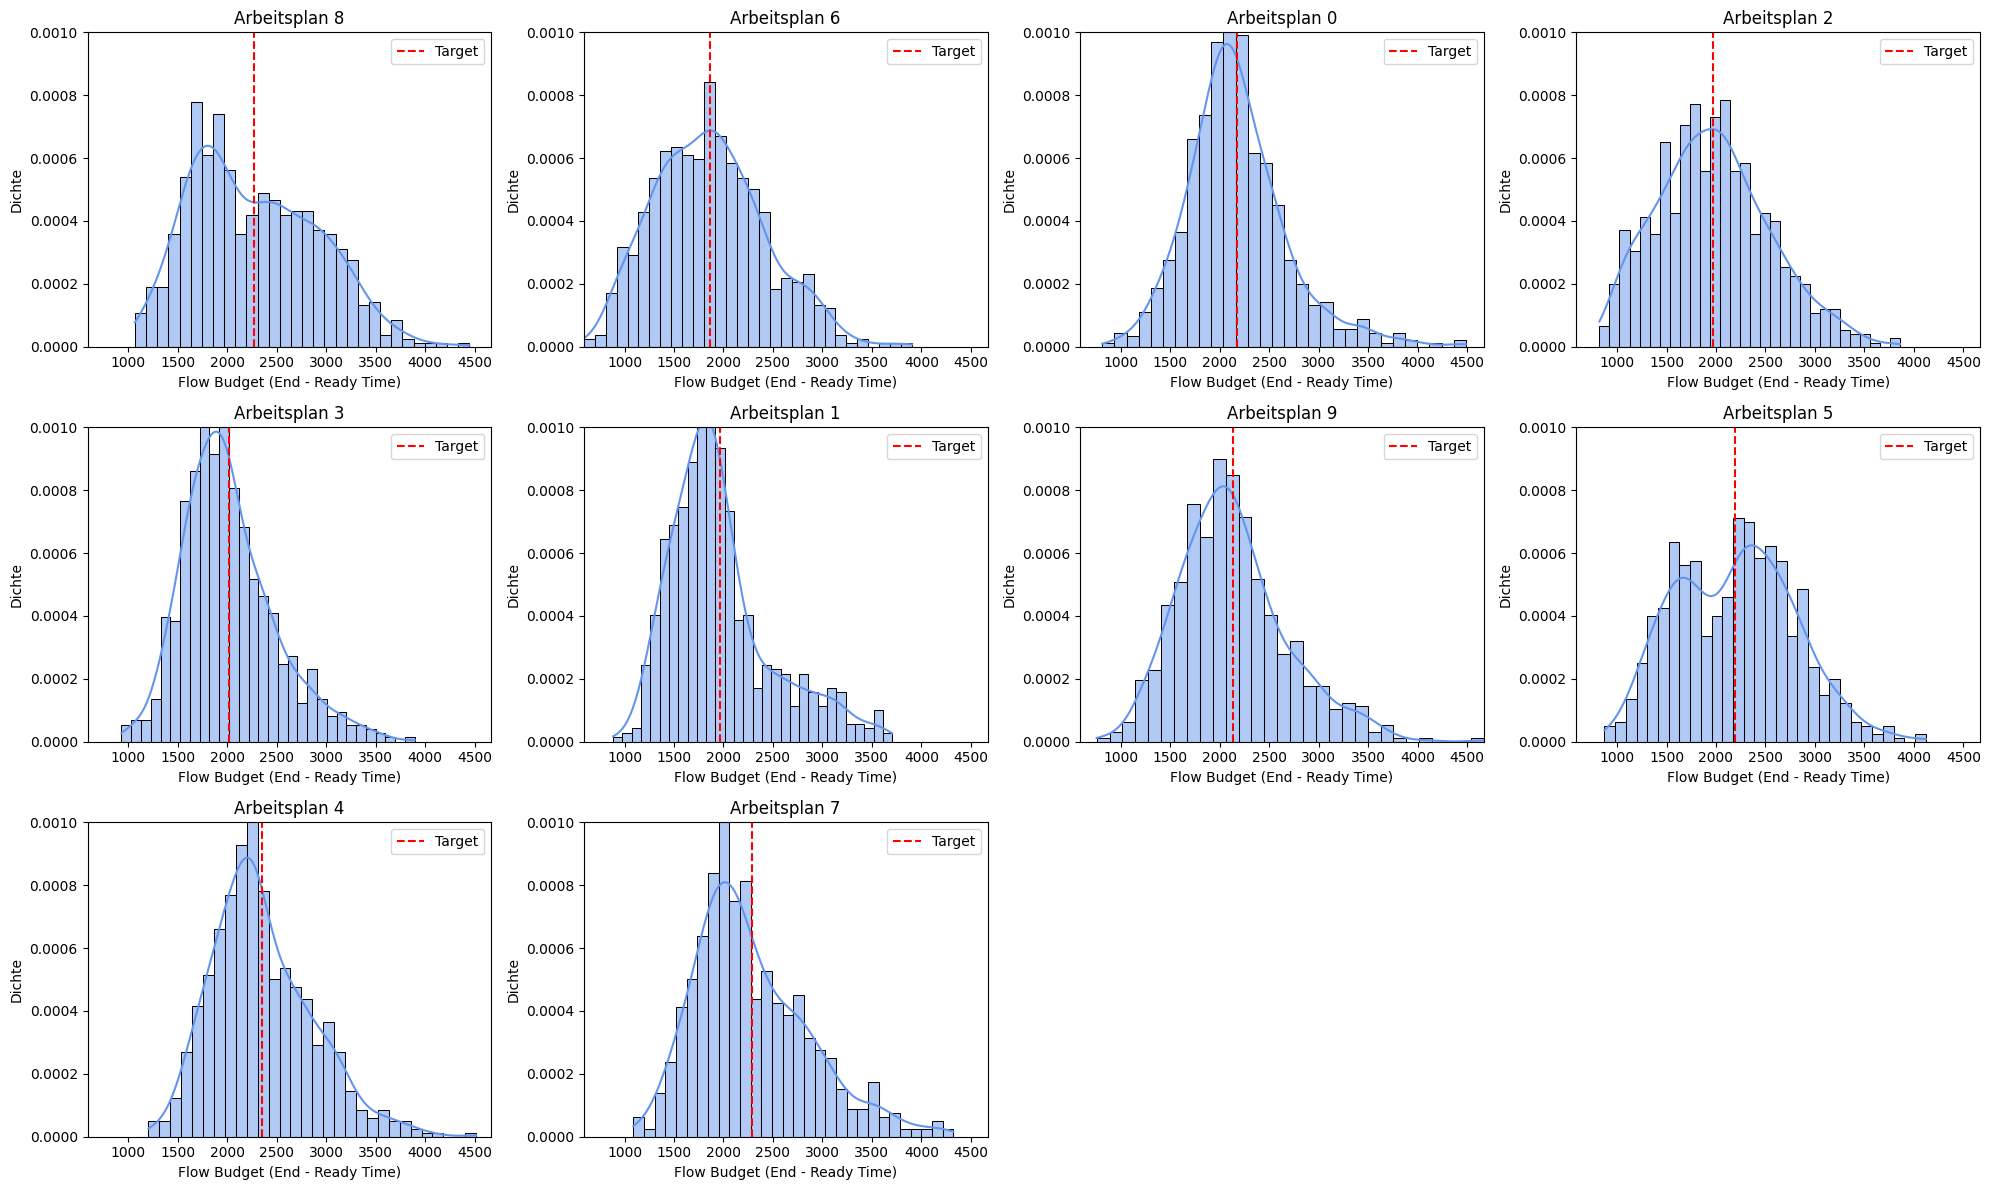

In [12]:
plotfig_empirical_flow_budget_distributions(df_jobs_times_temp, deadline_column="End")
plt.show()

### II. Generation of deadlines using log-normal distribution

In [13]:
df_jobs_times = add_groupwise_lognormal_deadlines_by_group_mean(df_jobs_times_temp, sigma=0.3)
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,0,1440,2898.0,597,3065.0
1,J25-0001,6,49,1440,2329.0,416,3493.0
2,J25-0002,0,116,1440,3024.0,395,3849.0
3,J25-0003,2,160,1440,2496.0,568,4606.0
4,J25-0004,3,203,1440,2789.0,655,3025.0
5,J25-0005,1,409,1440,2695.0,510,2717.0
...,...,...,...,...,...,...,...
7407,J25-7407,1,517827,518400,519820.0,510,520076.0
7408,J25-7408,7,517932,518400,520464.0,539,520867.0
7409,J25-7409,4,518012,518400,520466.0,393,520867.0


### b) Plot of the new deadlines

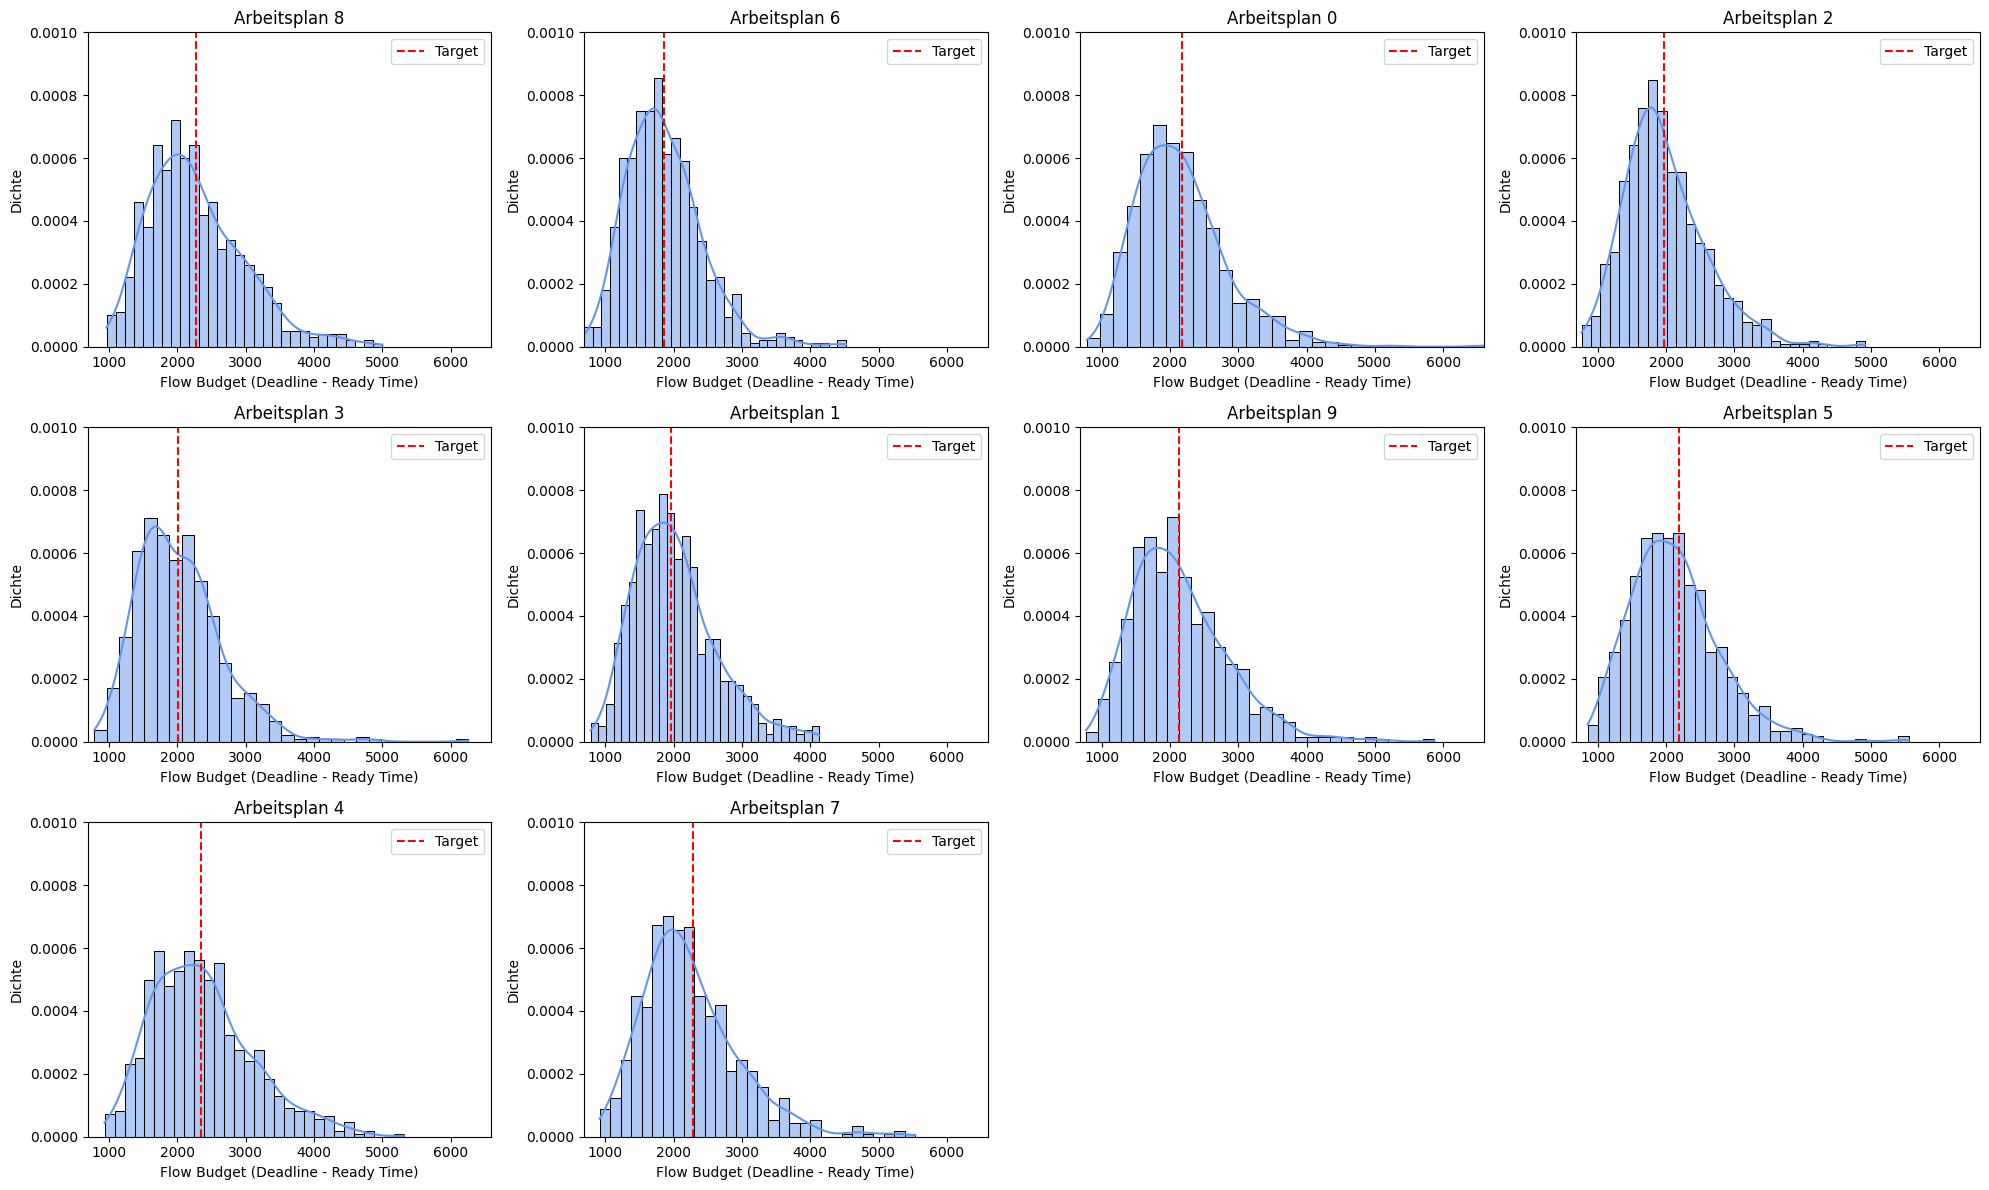

In [14]:
plotfig_empirical_flow_budget_distributions(df_jobs_times)
plt.show()

### c) Ensuring that the processing time is achievable to a certain extent in the best-case scenario

In [15]:
# min. 100 % of processing time for each job is covered in best-case
df_jobs_times_final = ensure_reasonable_deadlines(df_jobs_times, min_coverage = 1.0)

diff_count = (df_jobs_times_final["Deadline"] != df_jobs_times["Deadline"]).sum()

# Info: Compare the "Deadline" column
print(f"Number of different entries in 'Deadline': {diff_count}")

df_jobs_times_final

Number of different entries in 'Deadline': 0


,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,0,1440,597,3065
1,J25-0001,6,49,1440,416,3493
2,J25-0002,0,116,1440,395,3849
3,J25-0003,2,160,1440,568,4606
4,J25-0004,3,203,1440,655,3025
5,J25-0005,1,409,1440,510,2717
...,...,...,...,...,...,...
7407,J25-7407,1,517827,518400,510,520076
7408,J25-7408,7,517932,518400,539,520867
7409,J25-7409,4,518012,518400,393,520867


## Export

In [18]:
df_jobs_times_final.to_csv(basic_data_path / f"ft10_jobs_times.csv", index = False)